In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


In [2]:
N = 100; # neurons
log_g = tf.get_variable('g', shape=(), dtype=tf.float32);
g = tf.exp(log_g);
m = tf.get_variable('m', shape=(N,1), dtype=tf.float32);
n = tf.get_variable('n', shape=(N,1), dtype=tf.float32);

In [9]:
random_seed = 1;
np.random.seed(random_seed);
tf.random.set_random_seed(random_seed);

# define readout
w = m;

# define inputs
I_A = n;
I_B = np.random.normal(0,1.0,(N,1))

X_np = np.random.normal(0,1/np.sqrt(N), (N,N));
X = tf.constant(X_np, tf.float32);
P = tf.matmul(m,tf.transpose(n)) / N;
J = g*X + P;

x0 = np.random.normal(0,1,(N,1));
x0 = tf.constant(x0, dtype=tf.float32);

npts = 100;

def sim_RNN(J, I, x0, npts):
    x = x0;
    dt = 0.1;
    rs = [];
    for i in range(npts):
        r = tf.tanh(x);
        rs.append(r);
        xdot = -x + tf.matmul(J, r) + I;
        x = x+dt*xdot;
    return r, tf.stack(rs, axis=0)[:,:,0];

r_A, rs_A = sim_RNN(J, I_A, x0, npts);
r_B, rs_B = sim_RNN(J, I_B, x0, npts);


#z_As = tf.matmul(outs_A, w) / N;
#z_Bs = tf.matmul(outs_B, w) / N;

In [10]:
z_A = tf.tensordot(r_A, w, axes=[0,0]);
z_B = tf.tensordot(r_B, w, axes=[0,0]);

targ_A = 1.0;
targ_B = 0.0;
cost = tf.square(z_A-targ_A) + tf.square(z_B - targ_B);

lr = 1e-3;
optimizer = tf.train.AdamOptimizer(lr);
ts = optimizer.minimize(cost);

In [11]:
nits = 10000;
check_rate = 100;
costs = np.zeros((nits,));
tol = 1e-10;

gs = np.zeros((nits,));
Mms = np.zeros((nits,));
Mns = np.zeros((nits,));
Sims = np.zeros((nits,));
Sins = np.zeros((nits,));
mdotns = np.zeros((nits,));
mdotIBs = np.zeros((nits,));
ndotIBs = np.zeros((nits,));

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer());
    for i in range(nits):
        # take a gradient steps
        costs[i], _ts, _g, _m, _n = sess.run([cost, ts, g, m, n]);
        
        # record variables throughout training
        gs[i] = _g;
        Mms[i] = np.mean(_m);
        Mns[i] = np.mean(_n);
        Sims[i] = np.std(_m);
        Sins[i] = np.std(_n);
        mdotns[i] = np.dot(_m[:,0], _n[:,0]);
        mdotIBs[i] = np.dot(_m[:,0], I_B[:,0]);
        ndotIBs[i] = np.dot(_n[:,0], I_B[:,0]);
        
        # print output every so many iterationss
        if (np.mod(i, check_rate)==0):
            print('it %d' % i);
            _z_A, _z_B = sess.run([z_A, z_B]);
            print('A:', _z_A, 'B:', _z_B)
            
        # check for convergence
        if (costs[i] < tol):
            _z_A, _z_B = sess.run([z_A, z_B]);
            final_it = i;
            print('done at it %d' % i);
            print('A:', _z_A, 'B:', _z_B)
            break;
        

it 0
A: [[0.00417153]] B: [[-0.43227524]]
it 100
A: [[1.006176]] B: [[-0.00107135]]
it 200
A: [[0.99994624]] B: [[-3.3527613e-08]]
done at it 217
A: [[0.99999434]] B: [[3.3192337e-06]]


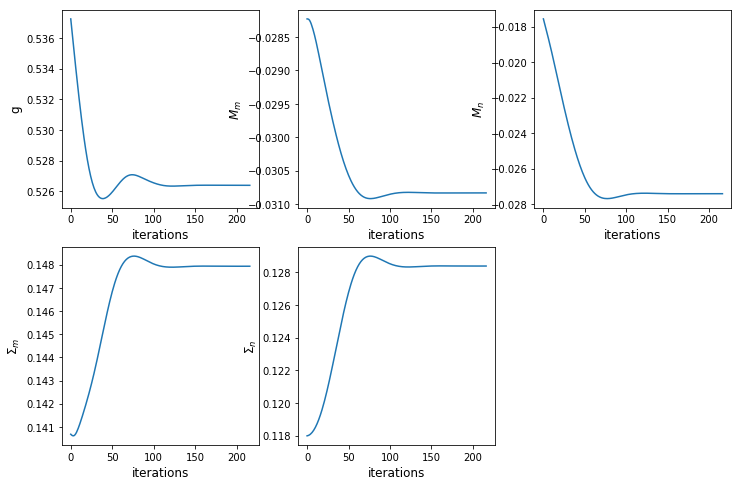

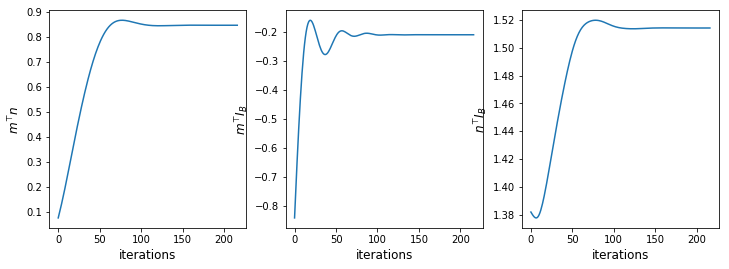

In [12]:
# analyze learned parameters

fontsize = 12;

iters = np.arange(final_it);
figsize = (12, 8);
plt.figure(figsize=figsize);

plt.subplot(2,3,1);
plt.plot(gs[:final_it]);
plt.xlabel('iterations', fontsize=fontsize);
plt.ylabel('g', fontsize=fontsize);

plt.subplot(2,3,2);
plt.plot(Mms[:final_it]);
plt.xlabel('iterations', fontsize=fontsize);
plt.ylabel(r'$M_m$', fontsize=fontsize);

plt.subplot(2,3,3);
plt.plot(Mns[:final_it]);
plt.xlabel('iterations', fontsize=fontsize);
plt.ylabel(r'$M_n$', fontsize=fontsize);

plt.subplot(2,3,4);
plt.plot(Sims[:final_it]);
plt.xlabel('iterations', fontsize=fontsize);
plt.ylabel(r'$\Sigma_m$', fontsize=fontsize);

plt.subplot(2,3,5);
plt.plot(Sins[:final_it]);
plt.xlabel('iterations', fontsize=fontsize);
plt.ylabel(r'$\Sigma_n$', fontsize=fontsize);
plt.show();


figsize = (12, 4);
plt.figure(figsize=figsize);
plt.subplot(1,3,1);
plt.plot(mdotns[:final_it]);
plt.xlabel('iterations', fontsize=fontsize);
plt.ylabel(r'$m^\top n$', fontsize=fontsize);

plt.subplot(1,3,2);
plt.plot(mdotIBs[:final_it]);
plt.xlabel('iterations', fontsize=fontsize);
plt.ylabel(r'$m^\top I_B$', fontsize=fontsize);

plt.subplot(1,3,3);
plt.plot(ndotIBs[:final_it]);
plt.xlabel('iterations', fontsize=fontsize);
plt.ylabel(r'$n^\top I_B$', fontsize=fontsize);